In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model

2023-12-18 00:27:23.908177: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


https://www.tensorflow.org/tutorials/structured_data/time_series

In [2]:
# LSTM global variables
# Sequences / window size
WINDOW_SIZE=20
# Number of days to forecast
FCST_AMT=30
# Epochs when training the model
EPOCHS=100

BATCH_SIZE=32
SHUFFLE_BUFFER_SIZE=1000

# Stock name
STOCK='TSLA'

In [3]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

## Load data

In [4]:
# # Get 5 years of data
# end = datetime.now()
# start = datetime(end.year - 5, end.month, end.day)

In [5]:
# Downloaded and saved to CSV the first time
# df = yf.download(STOCK, start, end)
# df.to_csv('TSLA_data.csv')

In [6]:
df=pd.read_csv('TSLA_data.csv')

In [7]:
df['Date']=pd.to_datetime(df['Date'])

In [8]:
df.set_index('Date',inplace=True)

In [9]:
series=df['Close'].values
time=pd.to_datetime(df.index.values)

In [10]:
df.dropna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-10,24.000000,24.398666,23.541332,24.343332,24.343332,99202500
2018-12-11,24.660667,24.811333,24.015333,24.450666,24.450666,94632000
2018-12-12,24.628000,24.794001,24.344000,24.440001,24.440001,75405000
2018-12-13,24.676666,25.162666,24.450001,25.119333,25.119333,110488500
2018-12-14,25.000000,25.191334,24.288668,24.380667,24.380667,95064000
...,...,...,...,...,...,...
2023-12-04,235.750000,239.369995,233.289993,235.580002,235.580002,104099800
2023-12-05,233.869995,246.660004,233.699997,238.720001,238.720001,137971100
2023-12-06,242.919998,246.570007,239.169998,239.369995,239.369995,126436200


## Split into train, validation and test sets 

In [11]:
# Split into train, validation and test sets (70,20,10 % split)
n = len(series)

# Train set
time_train = time[0:int(n*0.7)]
x_train = series[0:int(n*0.7)]

# Validation set
time_valid = time[int(n*0.7):int(n*0.9)]
x_valid = series[int(n*0.7):int(n*0.9)]

# Test set
time_test = time[int(n*0.9):]
x_test = series[int(n*0.9):]

In [12]:
test_split = int(n*0.9)

## Baseline MA model

In [13]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []

    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())

    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

In [14]:
# Compute MA predictions for entire dataframe then take just the test set slice (last 126 items)
ma_pred = moving_average_forecast(series, 30)[-(n - test_split):]

In [15]:
test_predictions = pd.DataFrame(ma_pred, index=time_test, columns=['Prediction'])

In [16]:
rmse = np.sqrt(mean_squared_error(x_test, test_predictions))
print(f'{STOCK} RMSE: {rmse:.2f}')

TSLA RMSE: 27.42


## Scale data

In [17]:
# Scale data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1,1))
x_valid_scaled = scaler.transform(x_valid.reshape(-1,1))
x_test_scaled = scaler.transform(x_test.reshape(-1,1))

## Prepare windowed data

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Most of this method comes from the coursera tensorflow developer course.
    
    Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    if shuffle_buffer is not None:
        dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [19]:
# Create windows for training dataset
dataset = windowed_dataset(x_train_scaled.flatten(), WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [20]:
# Create windows for validation set to pass into model
val_set = windowed_dataset(x_valid_scaled.flatten(), WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [21]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

## Build model for testing/tuning optimal learning rate

In [22]:
# # Set the learning rate scheduler
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))

In [23]:
# # Build the model
# model_tune = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#     LSTM(50, return_sequences=True),
#     Dropout(0.2),
#     LSTM(50, return_sequences=False),
#     Dropout(0.2),
#     Dense(1)
# ])

# # Set the optimizer
# optimizer = Adam(learning_rate=0.001)

# # Set the training parameters
# model_tune.compile(loss='mean_squared_error',
#               optimizer=optimizer,
#               metrics=[RootMeanSquaredError()])

In [24]:
#history = model_tune.fit(dataset, epochs=100, validation_data=val_set, callbacks=[lr_schedule])

In [25]:
# # Define the learning rate array
# lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# # Set the figure size
# plt.figure(figsize=(10, 6))

# # Set the grid
# plt.grid(True)

# # Plot the loss in log scale
# plt.semilogx(lrs, history.history["loss"])

# # Increase the tickmarks size
# plt.tick_params('both', length=10, width=1, which='both')

# # Set the plot boundaries
# plt.axis([1e-8, 1e-3, 0, 2])

## Train model with optimal learning rate
It appears that the optimal learning rate is about 0.001.

In [26]:
# Early stopping with validation set
# Save best model with a model checkpoint
cp = ModelCheckpoint(f'model1/', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [27]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Set the optimizer
optimizer = Adam(learning_rate=0.001)

# Set the training parameters
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])

# Train the model
model.fit(dataset,epochs=100, validation_data=val_set, callbacks=[es,cp])

Epoch 1/100
     25/Unknown - 3s 11ms/step - loss: 0.1826 - root_mean_squared_error: 0.4273INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 9s 225ms/step - loss: 0.1735 - root_mean_squared_error: 0.4165 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861
Epoch 2/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0427 - root_mean_squared_error: 0.2066INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 177ms/step - loss: 0.0421 - root_mean_squared_error: 0.2052 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1746
Epoch 3/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0323 - root_mean_squared_error: 0.1798 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 4/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0313 - root_mean_squared_error: 0.1769INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 194ms/step - loss: 0.0314 - root_mean_squared_error: 0.1772 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1523
Epoch 5/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0288 - root_mean_squared_error: 0.1697INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 191ms/step - loss: 0.0278 - root_mean_squared_error: 0.1668 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1476
Epoch 6/100
24/27 [=========================>....] - ETA: 0s - loss: 0.0266 - root_mean_squared_error: 0.1631INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 177ms/step - loss: 0.0262 - root_mean_squared_error: 0.1618 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1425
Epoch 7/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0240 - root_mean_squared_error: 0.1548 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1504
Epoch 8/100
27/27 [==============================] - ETA: 0s - loss: 0.0227 - root_mean_squared_error: 0.1507INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 176ms/step - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1367
Epoch 9/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0207 - root_mean_squared_error: 0.1439 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1400
Epoch 10/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0195 - root_mean_squared_error: 0.1397INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 187ms/step - loss: 0.0195 - root_mean_squared_error: 0.1396 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1274
Epoch 11/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0208 - root_mean_squared_error: 0.1442 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1373
Epoch 12/100
24/27 [=========================>....] - ETA: 0s - loss: 0.0198 - root_mean_squared_error: 0.1408INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 175ms/step - loss: 0.0191 - root_mean_squared_error: 0.1382 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 13/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1263
Epoch 14/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0192 - root_mean_squared_error: 0.1385INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 145ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 15/100
24/27 [=========================>....] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.1307INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 158ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1102
Epoch 16/100
23/27 [========================>.....] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.1344INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 161ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 17/100
27/27 [==============================] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.1326INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 157ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 18/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 19/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.1341INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 146ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 20/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0183 - root_mean_squared_error: 0.1354 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 21/100
27/27 [==============================] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.1304INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 159ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1030
Epoch 22/100
27/27 [==============================] - ETA: 0s - loss: 0.0186 - root_mean_squared_error: 0.1365INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 142ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988
Epoch 23/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051
Epoch 24/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.1257INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 172ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0971
Epoch 25/100
24/27 [=========================>....] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.1335INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 165ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0962
Epoch 26/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.1291INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 182ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 27/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0157 - root_mean_squared_error: 0.1255 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0946
Epoch 28/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.1294INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 180ms/step - loss: 0.0164 - root_mean_squared_error: 0.1281 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920
Epoch 29/100
27/27 [==============================] - 1s 17ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0987
Epoch 30/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 31/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0146 - root_mean_squared_error: 0.1210 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0943
Epoch 32/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 33/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 0.0085 - val_root_m

INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 189ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 35/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0152 - root_mean_squared_error: 0.1232 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 36/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917
Epoch 37/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1022
Epoch 38/100
24/27 [=========================>....] - ETA: 0s - loss: 0.0134 - root_mean_squared_error: 0.1158INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 169ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 39/100
23/27 [========================>.....] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1187INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 175ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 40/100
27/27 [==============================] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1154INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 176ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 41/100
23/27 [========================>.....] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.1226INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 182ms/step - loss: 0.0147 - root_mean_squared_error: 0.1214 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878
Epoch 42/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 43/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 44/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0151 - root_mean_squared_error: 0.1227 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889
Epoch 45/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 46/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 0.0112 - val_root_m

INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 174ms/step - loss: 0.0133 - root_mean_squared_error: 0.1151 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846
Epoch 49/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1170INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 171ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846
Epoch 50/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0138 - root_mean_squared_error: 0.1175 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0857
Epoch 51/100
27/27 [==============================] - 1s 18ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916
Epoch 52/100
27/27 [==============================] - 1s 17ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 53/100
27/27 [==============================] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.1147INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 174ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0834
Epoch 54/100
27/27 [==============================] - 1s 15ms/step - loss: 0.0132 - root_mean_squared_error: 0.1150 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 55/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0142 - root_mean_squared_error: 0.1191 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032
Epoch 56/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0131 - root_mean_squared_error: 0.1146INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 175ms/step - loss: 0.0134 - root_mean_squared_error: 0.1156 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823
Epoch 57/100
23/27 [========================>.....] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.1138INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 157ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810
Epoch 58/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0869
Epoch 59/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0134 - root_mean_squared_error: 0.1160 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840
Epoch 60/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819
Epoch 61/100
27/27 [==============================] - 1s 18ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 62/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.0086 - val_root_m

INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 157ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796
Epoch 67/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0116 - root_mean_squared_error: 0.1079 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881
Epoch 68/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 69/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1188INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 165ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786
Epoch 70/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805
Epoch 71/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1178INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 155ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0783
Epoch 72/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1179INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 186ms/step - loss: 0.0139 - root_mean_squared_error: 0.1179 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 73/100
27/27 [==============================] - 1s 16ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 74/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0797
Epoch 75/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.1118INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 188ms/step - loss: 0.0127 - root_mean_squared_error: 0.1127 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 76/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 77/100
27/27 [==============================] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.1149INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 188ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0774
Epoch 78/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794
Epoch 79/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 80/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 81/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 82/100
25/27 [==========================>...] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1100INFO:tensorflow:Assets written to: mo

INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 185ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0755
Epoch 83/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0825
Epoch 84/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824
Epoch 85/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 86/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0757
Epoch 87/100
23/27 [========================>.....] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1087INFO:tensorflow:Assets written to: mo

INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 4s 160ms/step - loss: 0.0117 - root_mean_squared_error: 0.1083 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 88/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0120 - root_mean_squared_error: 0.1098 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796
Epoch 89/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0104 - root_mean_squared_error: 0.1022 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857
Epoch 90/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 91/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820
Epoch 92/100
24/27 [=========================>....] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1063INFO:tensorflow:Assets written to: mo

INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 173ms/step - loss: 0.0113 - root_mean_squared_error: 0.1062 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0736
Epoch 93/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.1070INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 181ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 94/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726
Epoch 95/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 96/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0722
Epoch 97/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 98/100
26/27 [===========================>..] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1084INFO:tensorflow:Assets written to: mo

INFO:tensorflow:Assets written to: model1/assets


27/27 [==============================] - 5s 182ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 99/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818
Epoch 100/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0126 - root_mean_squared_error: 0.1125 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0741


## Predictions

In [28]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [29]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    labels=["True","Predicted"]
    l=0
    if type(series) is tuple:

        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format,label=labels[l])
            l+=1

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)
    
    # Add legend
    plt.gca().legend()

    # Draw the graph on screen
    plt.show()

## Show train predictions / model fit

In [30]:
# Use helper function to generate predictions
train_predictions = model_forecast(model, x_train_scaled[:-1], WINDOW_SIZE, BATCH_SIZE)

27/27 [==============================] - 1s 4ms/step


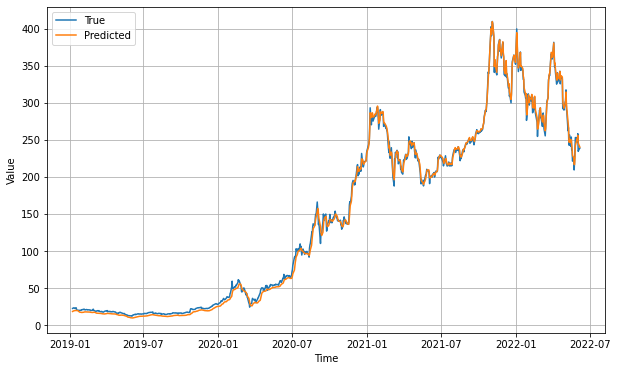

In [31]:
# Inverse transform
train_predictions = scaler.inverse_transform(train_predictions)

# Plot the results
plot_series(time_train[19:-1], (x_train[19:-1], train_predictions))

In [32]:
print(np.sqrt(tf.keras.metrics.mean_squared_error(x_train[19:-1], train_predictions.flatten()).numpy()))

4.4063835


## Load model and predict on test set

In [33]:
# Reduce the original series 
# Plot test set
# Align to predictions by shifting by window_size 
forecast_series = series[test_split - WINDOW_SIZE:-1]

In [34]:
forecast_series = scaler.transform(forecast_series.reshape(-1,1))

In [35]:
# Load best model
model = load_model(f'model1/')

4/4 [==============================] - 1s 9ms/step


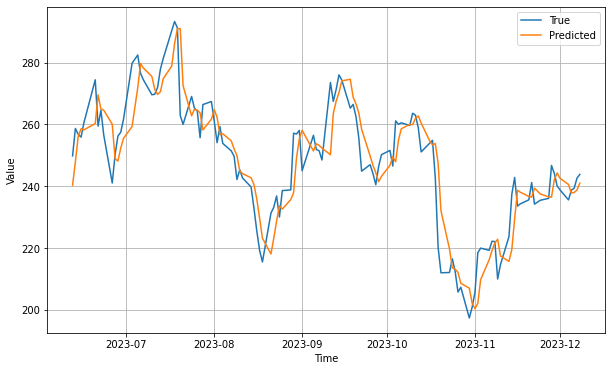

In [36]:
# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Inverse transform
results = scaler.inverse_transform(forecast)

# Plot the results
plot_series(time_test, (x_test, results))

In [37]:
# Compute the RMSE
print(np.sqrt(tf.keras.metrics.mean_squared_error(x_test.flatten(), results.flatten()).numpy()))

8.464573


## Forecast next 30 days

In [38]:
last_sequence = scaler.transform(series[-20:].reshape(-1,1))

In [39]:
last_sequence

array([[0.58380782],
       [0.65968076],
       [0.77441118],
       [0.81988457],
       [0.74242058],
       [0.74836652],
       [0.75925338],
       [0.80615042],
       [0.74761285],
       [0.75799713],
       [0.7632731 ],
       [0.85237761],
       [0.83077142],
       [0.79677104],
       [0.78630293],
       [0.75908585],
       [0.78538173],
       [0.7908251 ],
       [0.8182097 ],
       [0.82825905]])

In [40]:
def generate_forecasts(model, last_sequence, forecast_length=FCST_AMT):
    forecasts = []

    for _ in range(forecast_length):
        # Predict the next time step
        forecast = model.predict(tf.reshape(last_sequence, (1, WINDOW_SIZE, 1)))

        # Append the forecast to the results
        forecasts.append(forecast[0, 0])

        # Update the last sequence for the next prediction
        # "Roll" the first data point to the bottom of the list
        # This is so it can be deleted and replaced and the window will 
        # keep shifting down 
        last_sequence = np.roll(last_sequence, -1)
        # Replace the last element with the latest forecast
        last_sequence[-1] = forecast[0, 0]

    return forecasts

In [41]:
forecasts = generate_forecasts(model, last_sequence)

1/1 [==============================] - 0s 18ms/step


In [42]:
y_future = scaler.inverse_transform(np.array(forecasts).reshape(-1,1))

In [43]:
y_future.flatten()

array([242.91556, 243.2696 , 243.41116, 243.51157, 243.59508, 243.66353,
       243.71982, 243.7642 , 243.79808, 243.8194 , 243.83064, 243.83269,
       243.82901, 243.81834, 243.80153, 243.78009, 243.75443, 243.72665,
       243.69691, 243.6664 , 243.63515, 243.6031 , 243.57071, 243.53807,
       243.50542, 243.47285, 243.44049, 243.40842, 243.37674, 243.34549],
      dtype=float32)

## Visualize forecast

In [44]:
data = df.filter(['Close'])

In [45]:
# Organize results in dataframe
df_past = data[['Close']].reset_index()
df_past.rename(columns={'index': 'Date'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan

df_future = pd.DataFrame(columns=['Date', 'Close', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=FCST_AMT)
df_future['Forecast'] = y_future.flatten()
df_future['Close'] = np.nan

results = df_past.append(df_future).set_index('Date')

/var/folders/5n/9_pt9s2n7w96mvzm_z6s8q5r0000gn/T/ipykernel_70023/2261972395.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


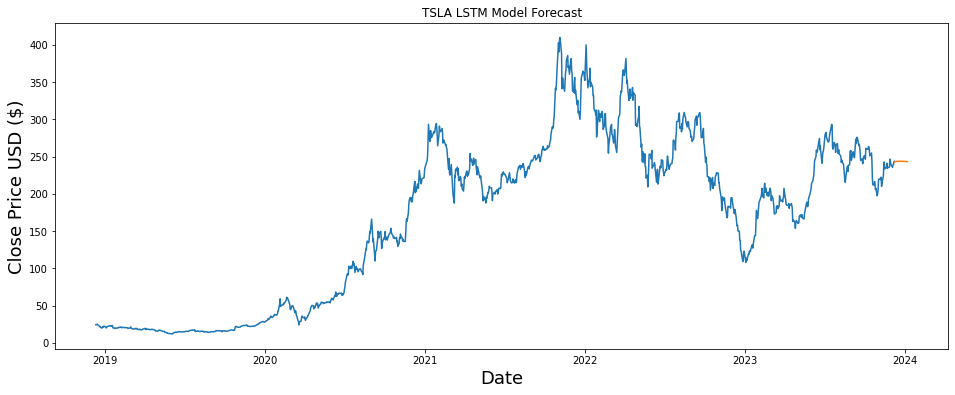

In [46]:
# Plot results
plt.figure(figsize=(16,6))
plt.title(f'{STOCK} LSTM Model Forecast')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(results['Close'])
plt.plot(results['Forecast'])